In [50]:
from datetime import date

from openfisca_france import init_country
from openfisca_france.model.base import *

# to debug / trace
from openfisca_core import web_tools

## Adaptation pour faciliter l'usage de ce notebook

_Ce correctif permet de redéfinir plusieurs fois la même variable sans provoquer d'erreur._

In [68]:
import functools

from openfisca_france.entities import entity_class_by_symbol

# reference_formula = make_reference_formula_decorator(entity_class_by_symbol = entity_class_by_symbol, update = True)
# reference_input_variable = functools.partial(reference_input_variable, update = True)

# Système socio-fiscal

In [52]:
TaxBenefitSystem = init_country()
tax_benefit_system = TaxBenefitSystem()

In [53]:
from openfisca_core import reforms

In [54]:
ReformeRevenuDeBase = reforms.make_reform(
    key = 'reforme_rdb',
    name = u"Réforme Revenu de base",
    reference = tax_benefit_system,
    )

# Réforme : 1. Revenu de base

In [55]:
from numpy import logical_not as not_, minimum as min_, maximum as max_, logical_and as and_, logical_or as or_
#- Hausse de la CSG déductible au taux de 20%
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire
#- Intégrer le revenu de base au revenu disponible
#- Mise en place d'un crédit d'impot familles monoparentales montant ??? (50€)
#- Supprimer le RSA


#-Visualisation graphique en abscisse salaire brut et en ordonnée variation du revenu disponible 
# pour un célibataire sans enfant
# pour un couple sans enfant
# une famille monoparentale


#(- Nouveau calcul de l'IRPP)


In [56]:
#- Hausse de la CSG déductible au taux de 20%
#montant_csg_crds calcul à partir law_node.taux-plein law_node.taux_réduit et law_node.taux
import json
#- Hausse de la CSG déductible au taux de 20%
#montant_csg_crds calcul à partir law_node.taux-plein law_node.taux_réduit et law_node.taux
def modify_legislation_json(reference_legislation_json_copy):
    for value_json in reference_legislation_json_copy['children']['csg']['children']['activite']['children']['deductible']['children']['taux']['values']:
        value_json['value'] = 0.20
    return reference_legislation_json_copy



In [71]:
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire

class rdb(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age') 
        rmi = simulation.legislation_at(period.start).minim.rmi
        
        return period, ((age >= 18) * rmi.rmi * ( 1 - rmi.forfait_logement.taux1) + not_(age >= 18) * 0)



AssertionError: rdb

In [58]:
#- Intégrer le revenu de base au revenu disponible
class revdisp(ReformeRevenuDeBase.Variable):
    reference = Menages.column_by_name['revdisp']

    def function(self, simulation, period):
        '''
        Revenu disponible - ménage
        'men'
        '''
        period = period.start.period('year').offset('first-of') 
        rev_trav_holder = simulation.compute('rev_trav', period)
        pen_holder = simulation.compute('pen', period)
        rev_cap_holder = simulation.compute('rev_cap', period)
        psoc_holder = simulation.compute('psoc', period)
        ppe_holder = simulation.compute('ppe', period)
        impo = simulation.calculate('impo', period)
        rdb_holder = simulation.calculate_add('rdb', period)
        credit_impot_familles_holder = simulation.calculate_add('credit_impot_familles', period)

        pen = self.sum_by_entity(pen_holder) 
        ppe = self.cast_from_entity_to_role(ppe_holder, role = VOUS)
        ppe = self.sum_by_entity(ppe)
        psoc = self.cast_from_entity_to_role(psoc_holder, role = CHEF)
        psoc = self.sum_by_entity(psoc)
        rev_cap = self.sum_by_entity(rev_cap_holder)
        rev_trav = self.sum_by_entity(rev_trav_holder)
        rdb = self.sum_by_entity(rdb_holder)
        credit_impot_familles = self.sum_by_entity(credit_impot_familles_holder)
        
        return period, rev_trav + pen + rev_cap + psoc + ppe + impo + rdb + credit_impot_familles

In [59]:
#- Mise en place d'un crédit d'impot familles monoparentales montant (150€)
class credit_impot_familles(ReformeRevenuDeBase.Variable):
    column = FloatCol
    entity_class = Individus
    label = u"credit_impot_familles"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age_holder = simulation.calculate('age')
        nb_enf_a_charge = simulation.calculate('enfant_a_charge',period)
        caseT = simulation.calculate('caseT',period) #Egal True si le parent est isolé
      
        
        #return period, or_(and_(age_holder >= 18, nb_enf_a_charge > 0, caseT), or_(age_holder < 18, nb_enf_a_charge <= 0, not_(caseT)) * 0) * 100
        return period, self.zeros() + (age_holder >= 18) * (nb_enf_a_charge > 0) * (caseT) * 150
    #Si le parent est isolé, avec au moins un enfant, et qu'il est majeur il reçoit la pension

In [60]:
#- Supprimer le RSA
class rsa_socle(ReformeRevenuDeBase.Variable):
    reference = Familles.column_by_name['rsa_socle']

    def function(self, simulation, period):
        period = period.this_month
        nb_par = simulation.calculate('nb_par', period)
        eligib = simulation.calculate('rsa_eligibilite', period)
        nb_enfant_rsa = simulation.calculate('nb_enfant_rsa', period)
        rmi = simulation.legislation_at(period.start).minim.rmi

        nbp = nb_par + nb_enfant_rsa

        taux = (
            1 +
            (nbp >= 2) * rmi.txp2 +
            (nbp >= 3) * rmi.txp3 +
            (nbp >= 4) * ((nb_par == 1) * rmi.txps + (nb_par != 1) * rmi.txp3) +
            max_(nbp - 4, 0) * rmi.txps
        )
        #on met à zéro
        return period, eligib * rmi.rmi * taux * 0


# Suppression des allocations familiales
@ReformeRevenuDeBase.add_column
class af(Variable):
    reference = Familles.column_by_name['af']

    def function(self, simulation, period):
        period = period.this_month
        af_base = simulation.calculate('af_base', period)
        af_majo = simulation.calculate('af_majo', period)
        af_forf = simulation.calculate('af_forf', period)

        #return period, af_base + af_majo + af_forf
        return period, af_base * 0

# Tests

In [61]:
reform = ReformeRevenuDeBase()
reform.modify_legislation_json(modifier_function = modify_legislation_json)

In [62]:
parent1_salaire_de_base = 50000

In [63]:
scenario_ref_individu_seul = tax_benefit_system.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        birth = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    )
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [64]:
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = 2014,
    parent1 = dict(
        birth = date(1980, 1, 1),
        salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    )
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

In [65]:
# Reference
simulation_ref_individu_seul.calculate('revdisp')

array([ 35990.39453125], dtype=float32)

In [66]:
simulation_ref_individu_seul.calculate('irpp')

array([-5346.21435547], dtype=float32)

In [67]:
simulation_ref_individu_seul.calculate_add('rsa')

array([ 499.30999756], dtype=float32)

In [22]:
simulation_ref_individu_seul.calculate('csg_imposable_salaire')

array([-1178.99902344], dtype=float32)

In [23]:
simulation_ref_individu_seul.calculate('csg_deductible_salaire')

array([-2505.37231445], dtype=float32)

In [24]:
simulation_ref_individu_seul.calculate('tot_impot')

array([ 9278.70703125], dtype=float32)

In [25]:
# Avec RDB
simulation_rdb_individu_seul.calculate('revdisp')

array([ 35303.47265625], dtype=float32)

In [26]:
simulation_rdb_individu_seul.calculate('irpp')

array([-3369.62670898], dtype=float32)

In [27]:
simulation_rdb_individu_seul.calculate('csg_imposable_salaire')

array([-1178.99902344], dtype=float32)

In [28]:
simulation_rdb_individu_seul.calculate('csg_deductible_salaire')

array([-9824.9921875], dtype=float32)

In [29]:
simulation_rdb_individu_seul.calculate('tot_impot')

array([ 14619.2421875], dtype=float32)

In [30]:
# trace
simulation_rdb_individu_seul.calculate('tot_impot')
#print web_tools.get_trace_tool_link(scenario, ['tot_impot'])

array([ 14619.2421875], dtype=float32)

In [ ]:
simulation_rdb_individu_seul.calculate('rdb')

In [49]:
# Graphique
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# REFERENCE
year = 2014
scenario_ref_individu_seul = tax_benefit_system.new_scenario().init_single_entity(
    period = year,
    parent1 = dict(
        birth = date(1980, 1, 1),
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    axes = [[
            dict(
                count = 13,
                min = 0,
                max = 60000,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = 13,
                min = 0,
                max = 60000,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = 13,
                min = 0,
                max = 60000,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
)
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [32]:
# RDB
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = year,
    parent1 = dict(
        birth = date(1980, 1, 1),
        #salaire_de_base = parent1_salaire_de_base,
        statmarit = u'Célibataire',
    ),
    foyer_fiscal = dict(
        caseT = True,
    ),
    enfants = [],
    axes = [
            dict(
                count = 13,
                min = 0,
                max = 60000,
                name = 'salaire_de_base',
                period = year,            
                ),
            ],
    )
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

In [33]:
salaire_de_base = simulation_ref_individu_seul.calculate("salaire_de_base")

In [34]:
revenu_disponible_ref = simulation_ref_individu_seul.calculate_add("revdisp")
rsa_ref = simulation_ref_individu_seul.calculate_add("rsa")
revenu_disponible_ref = simulation_rdb_individu_seul.calculate_add("salaire_net")


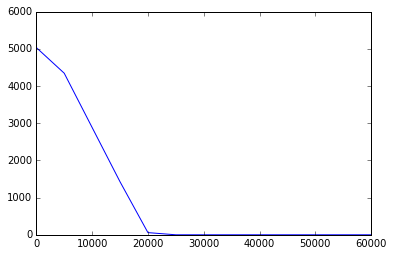

In [35]:
# plt.plot(salaire_de_base[::1], revenu_disponible_ref, salaire_de_base[::1], revenu_disponible_rdb, salaire_de_base[::1], rsa_ref)
plt.plot(salaire_de_base[::1], rsa_ref)

In [36]:
def make_alone_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = 60000, count = 13):
    enfant = [dict(
        birth = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year-2,
                ),
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year-1,
                ),
            dict(
                count = count,
                min = 0,
                max = ax_variable_max,
                name = axes_variable,
                period = year,
                ),
            ]],
        period = year,
        parent1 = dict(
            birth = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 1000,
            statut_occupation = 4,
            ),
        )
    return scenario

In [41]:
scenario_alone_ref = make_alone_scenario(0, 2014)
simulation_alone_ref = scenario_alone_ref.new_simulation()

In [42]:
scenario_alone_reform = make_alone_scenario(0, 2014, reform)
simulation_alone_reform = scenario_alone_reform.new_simulation()

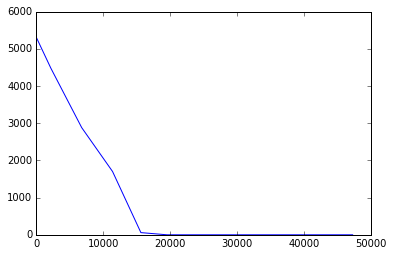

In [47]:
salaire_net_ref = simulation_alone_ref.calculate_add('salaire_net')
rsa_ref = simulation_alone_ref.calculate_add('rsa')
salaire_net_reform = simulation_alone_reform.calculate_add('salaire_net')
rsa_reform = simulation_alone_reform.calculate_add('rsa')
plt.plot(salaire_net_ref, rsa_ref)

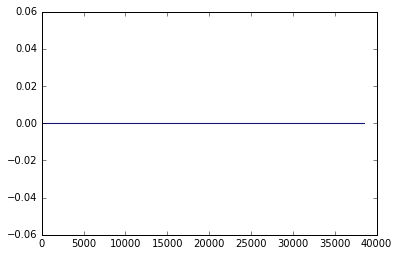

In [48]:
plt.plot(salaire_net_reform, rsa_reform)